# GOAL

We want to examine the variance raw and normalized sample coverage in sWGA Field Isolates.  Specifically, do we see patterns in the coverage spikes across samples?

In [2]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [19]:
PF_FIELD_GDNA_COV_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/pysamstats_gc"
GAUSSIAN_HMM_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/gaussian_hmm_cnv"


In [4]:
# bsub < ~/gitrepo/pf_swga_cnv/src/shell/gaussian_hmm_cnv_wgs.lsf 

In [4]:
def get_norm_gc(pysam_gc_stats_tsv, chroms):
    df_list = []
    for chrom in chroms:
        pysam_gc_stats_chrom_tsv = pysam_gc_stats_tsv.replace("{CHROM}", chrom)
        # Per-position GC content, read coverage.  
        # We don't care about properly paired reads here, since there could be 
        # inversions, deletions, insertions that alter orientation of read pairs.
        pysam_gc = pandas.read_csv(pysam_gc_stats_chrom_tsv, sep="\t")
        # Indicate the window start position
        pysam_gc["window"] =  300 * (pysam_gc.pos // 300)

        # Aggregate reads by window
        pysam_gc_win = pysam_gc.groupby(["chrom", "window"]).agg({'gc': {"gc_win_med": "median", 'gc_win_mean': "mean"},
                                                  'reads_all': {"reads_all_win_med": "median", 
                                                                'reads_all_win_mean': "mean"}})
        pysam_gc_win.columns = pysam_gc_win.columns.droplevel()
        # Label each window with the ave gc_bin content
        pysam_gc_win["gc_bin"] =  pysam_gc_win["gc_win_mean"].apply(np.floor)

        # Find the mean reads in each GC Bin
        pysam_gc_per_pos_per_win = pysam_gc.reset_index().set_index(["chrom", "window"]).join(pysam_gc_win[["gc_bin"]])

        pysam_by_gc_bin = pysam_gc_per_pos_per_win.reset_index().groupby("gc_bin").agg({'reads_all': "mean"})
        pysam_by_gc_bin = pysam_by_gc_bin.rename(columns={'reads_all': 'reads_all_gc_bin_mean'})

        pysam_per_win_per_gc_bin = pysam_gc_win.reset_index().set_index("gc_bin").join(pysam_by_gc_bin, rsuffix="_median")
        pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.reset_index()
        pysam_per_win_per_gc_bin["window"] = pysam_per_win_per_gc_bin["window"].astype(float)
        pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.sort_values("window")

        pysam_per_win_per_gc_bin["norm_reads_all"] = pysam_per_win_per_gc_bin["reads_all_win_mean"] / pysam_per_win_per_gc_bin["reads_all_gc_bin_mean"]

        df_list.append(pysam_per_win_per_gc_bin)
    
    pysam_per_win_per_gc_bin_concat = pandas.concat(df_list)
    return pysam_per_win_per_gc_bin_concat

In [28]:
def get_many_norm_gc(pysam_gc_stats_dir):
    """
    Gets per-window coverage for many samples.  
    Each sample should have a separate pysamstats_gc tsv in the same directory.
    """
    sample_stats_list = []
    # HACK:  filter for only the 36 samples that were 36plexed and swgaed for 16 hours
    for i, pysam_gc_stats_tsv in enumerate(glob.glob(pysam_gc_stats_dir + os.sep + "*.20295_4*.pysamstats_gc.txt")):
#         display(pysam_gc_stats_tsv)
        pysamstat = get_norm_gc(pysam_gc_stats_tsv = pysam_gc_stats_tsv)
#         display(pysamstat.shape)
#         display(pysamstat.head())
#         display(pysamstat.describe())
        
#         if i > 2:
#             break;
            
        sample_stats_list.append(pysamstat)
    
    all_samples_metrics = pandas.concat(sample_stats_list)
    return all_samples_metrics
    
        

In [6]:

def fit_hmm(depth_normed,  # normalised coverage array 
            transition_probability,  # probability of state transition
            variance,  # variance per copy 
            variance_fixed,  # variance for the zero copy number state 
            min_swga_copy_number=0,  # minimum copy number to consider in the model
            max_swga_copy_number=5,  # maximum copy number to consider in the model 
            n_iter=0,  # number of iterations to perform when fitting the model
            params='st',  # parameters that can be changed through fitting 
            init_params='',  # parameters that are initialised from the data
           ):
    
    # convenience variable
    n_states = max_swga_copy_number - min_swga_copy_number
    
    # construct the transition matrix
    transmat = np.zeros((n_states, n_states))
    transmat[:] = transition_probability
    transmat[np.diag_indices(n_states)] = 1-((n_states-1)*transition_probability)
    display("transmat")
    display(transmat)

    # construct means and covariance
    means = np.array([[n] for n in range(min_swga_copy_number, max_swga_copy_number)])
    covars = np.array([[variance*n + variance_fixed] for n in range(min_swga_copy_number, max_swga_copy_number)])

    # setup HMM 
    model = hmm.GaussianHMM(n_states, 
                        covariance_type='diag', 
                        n_iter=n_iter, 
                        transmat_prior=transmat, 
                        params=params,
                        init_params=init_params)
    model.means_ = means
    model.covars_ = covars
    
    # fit HMM
    obs = np.column_stack([depth_normed])
    display("obs")
    display(obs)
#     obs = depth_normed
    model.fit(obs)
    
    # predict hidden states
    h = model.predict(obs)
    
    return h

In [29]:
pysamstats_per_win = get_many_norm_gc(PF_FIELD_GDNA_COV_DIR)
display(pysamstats_per_win.shape)
display(pysamstats_per_win.head())
display(pysamstats_per_win.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(157058, 8)

,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
4184,30.0,2700.0,1.000000,1.0,31.388889,31.0,21.713320,0.046055
4185,30.0,3000.0,1.000000,1.0,31.744361,32.0,21.713320,0.046055
2552,20.0,19200.0,1.000000,1.0,25.235294,25.0,56.114978,0.017821
2553,20.0,19500.0,2.162963,2.0,26.559259,26.0,56.114978,0.038545
169,10.0,19800.0,1.352679,1.0,18.705357,19.0,92.865997,0.014566


,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
count,157058.000000,1.570580e+05,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000
mean,14.177692,6.804317e+05,87.138794,86.956280,18.994795,18.990287,87.719001,0.989463
std,6.387250,3.789764e+05,152.134632,151.114574,5.818773,5.941164,25.542959,1.737245
min,0.000000,9.000000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.007145
25%,10.000000,3.525000e+05,23.440000,23.000000,14.646667,15.000000,78.433042,0.292431
50%,10.000000,6.804000e+05,50.581667,50.000000,18.803333,19.000000,91.308496,0.584780
75%,20.000000,1.007700e+06,99.290000,99.000000,22.556667,23.000000,104.066157,1.104897
max,50.000000,1.342800e+06,7916.820000,7942.000000,52.166667,52.000000,139.959508,102.605036


Total sWGA Field Isolate Samples:

In [ ]:
display(len(pysamstats_per_win["sample"].unique()))

# Raw Coverage for all sWGA Samples

In [ ]:
# Plot Raw Coverage along genome
samples = pysamstats_per_win["sample"].unique()
total_samples = len(samples)
total_cols = 3
total_rows = 1 + (total_samples // total_cols)
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = pysamstats_per_win[(pysamstats_per_win["sample"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.scatter(subset["window"], subset["reads_all_win_mean"], c="orange", alpha=0.2)

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Normalized Coverage")
        ax.set_xlabel("Site")
        

plt.tight_layout()
plt.show()

# Normalized Coverage for all sWGA Samples

In [ ]:
# Plot Raw Coverage along genome
samples = pysamstats_per_win["sample"].unique()
total_samples = len(samples)
total_cols = 3
total_rows = 1 + (total_samples // total_cols)
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = pysamstats_per_win[(pysamstats_per_win["sample"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.scatter(subset["window"], subset["norm_reads_all"], c="orange", alpha=0.2)

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Normalized Coverage")
        ax.set_xlabel("Site")
        

plt.tight_layout()
plt.show()

# Field Isolate sWGA Copy Number Calls from Gaussian HMM on GC Normalized Coverage

In [11]:
def get_hmm_cnv_calls(calls_dir):
    sample_stats_list = []
    # Expect <sample>.<library>.<lane>.cnv.tsv
    for i, cnv_call_tsv in enumerate(glob.glob(calls_dir + os.sep + "*cnv.tsv")):
        
        sample_stats = pandas.read_csv(cnv_call_tsv, sep="\t", 
                                  comment="#", skip_blank_lines=True)
        
        sample, library, lane = os.path.basename(cnv_call_tsv).split(".")[:3]
        sample_stats["sample"] = sample
        sample_stats["library"] = library
        sample_stats["lane"] = lane
#         display(sample_stats)
        
#         if i > 2:
#             break
            
        sample_stats_list.append(sample_stats)


    all_samples_metrics = pandas.concat(sample_stats_list)
    return all_samples_metrics

In [15]:
cnv_calls = get_hmm_cnv_calls(GAUSSIAN_HMM_DIR)
display(cnv_calls.shape)
display(cnv_calls.head())
display(cnv_calls.tail())
display(cnv_calls.describe())

(182934, 12)

,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
0,1,40.0,47.057348,47.0,18091_1#12,15108291,0.122171,108.491118,13.254480,9.0,3909STDY6204220,0.0
1,1,30.0,39.426160,41.0,18091_1#12,15108291,0.352333,124.390949,43.827004,51.0,3909STDY6204220,300.0
2,1,20.0,28.236667,28.0,18091_1#12,15108291,0.574450,137.139880,78.780000,83.5,3909STDY6204220,600.0
3,1,20.0,26.716667,26.0,18091_1#12,15108291,0.652691,137.139880,89.510000,88.0,3909STDY6204220,900.0
4,1,30.0,31.523333,32.0,18091_1#12,15108291,0.722802,124.390949,89.910000,80.5,3909STDY6204220,1200.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
4468,1,20.0,29.456667,30.0,13284_8#72,10367390,1.217353,203.441337,247.660000,251.0,3061STDY5801276,1342200.0
4469,1,20.0,29.796667,30.0,13284_8#72,10367390,0.837539,203.441337,170.390000,170.0,3061STDY5801276,1342500.0
4470,1,30.0,35.840000,34.0,13284_8#72,10367390,0.474750,186.603632,88.590000,43.0,3061STDY5801276,1342800.0
4471,1,40.0,45.600000,46.0,13284_8#72,10367390,0.162873,161.843769,26.360000,27.0,3061STDY5801276,1343100.0
4472,1,40.0,44.732484,45.0,13284_8#72,10367390,0.171235,161.843769,27.713376,33.0,3061STDY5801276,1343400.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,window
count,182934.000000,182934.000000,182934.000000,182934.000000,182934.000000,182934.000000,182934.000000,182934.000000,1.829340e+05
mean,1.141505,14.471831,19.280807,19.277204,0.994302,120.994196,120.305331,120.665049,6.725468e+05
std,0.396305,6.694064,6.147413,6.262955,0.501173,59.248059,79.900563,81.092690,3.865256e+05
min,0.000000,0.000000,1.453184,1.000000,0.003178,1.000000,1.000000,1.000000,0.000000e+00
25%,1.000000,10.000000,14.726667,15.000000,0.627147,87.361071,51.886667,50.000000,3.381000e+05
50%,1.000000,10.000000,18.943333,19.000000,0.993432,107.139677,105.051667,107.000000,6.726000e+05
75%,1.000000,20.000000,22.806667,23.000000,1.228810,169.777135,184.776667,186.000000,1.007100e+06
max,4.000000,50.000000,52.722222,53.000000,8.421705,314.672826,995.726667,959.000000,1.343400e+06


Total Samples

In [16]:
display(len(cnv_calls["sample"].unique()))

41

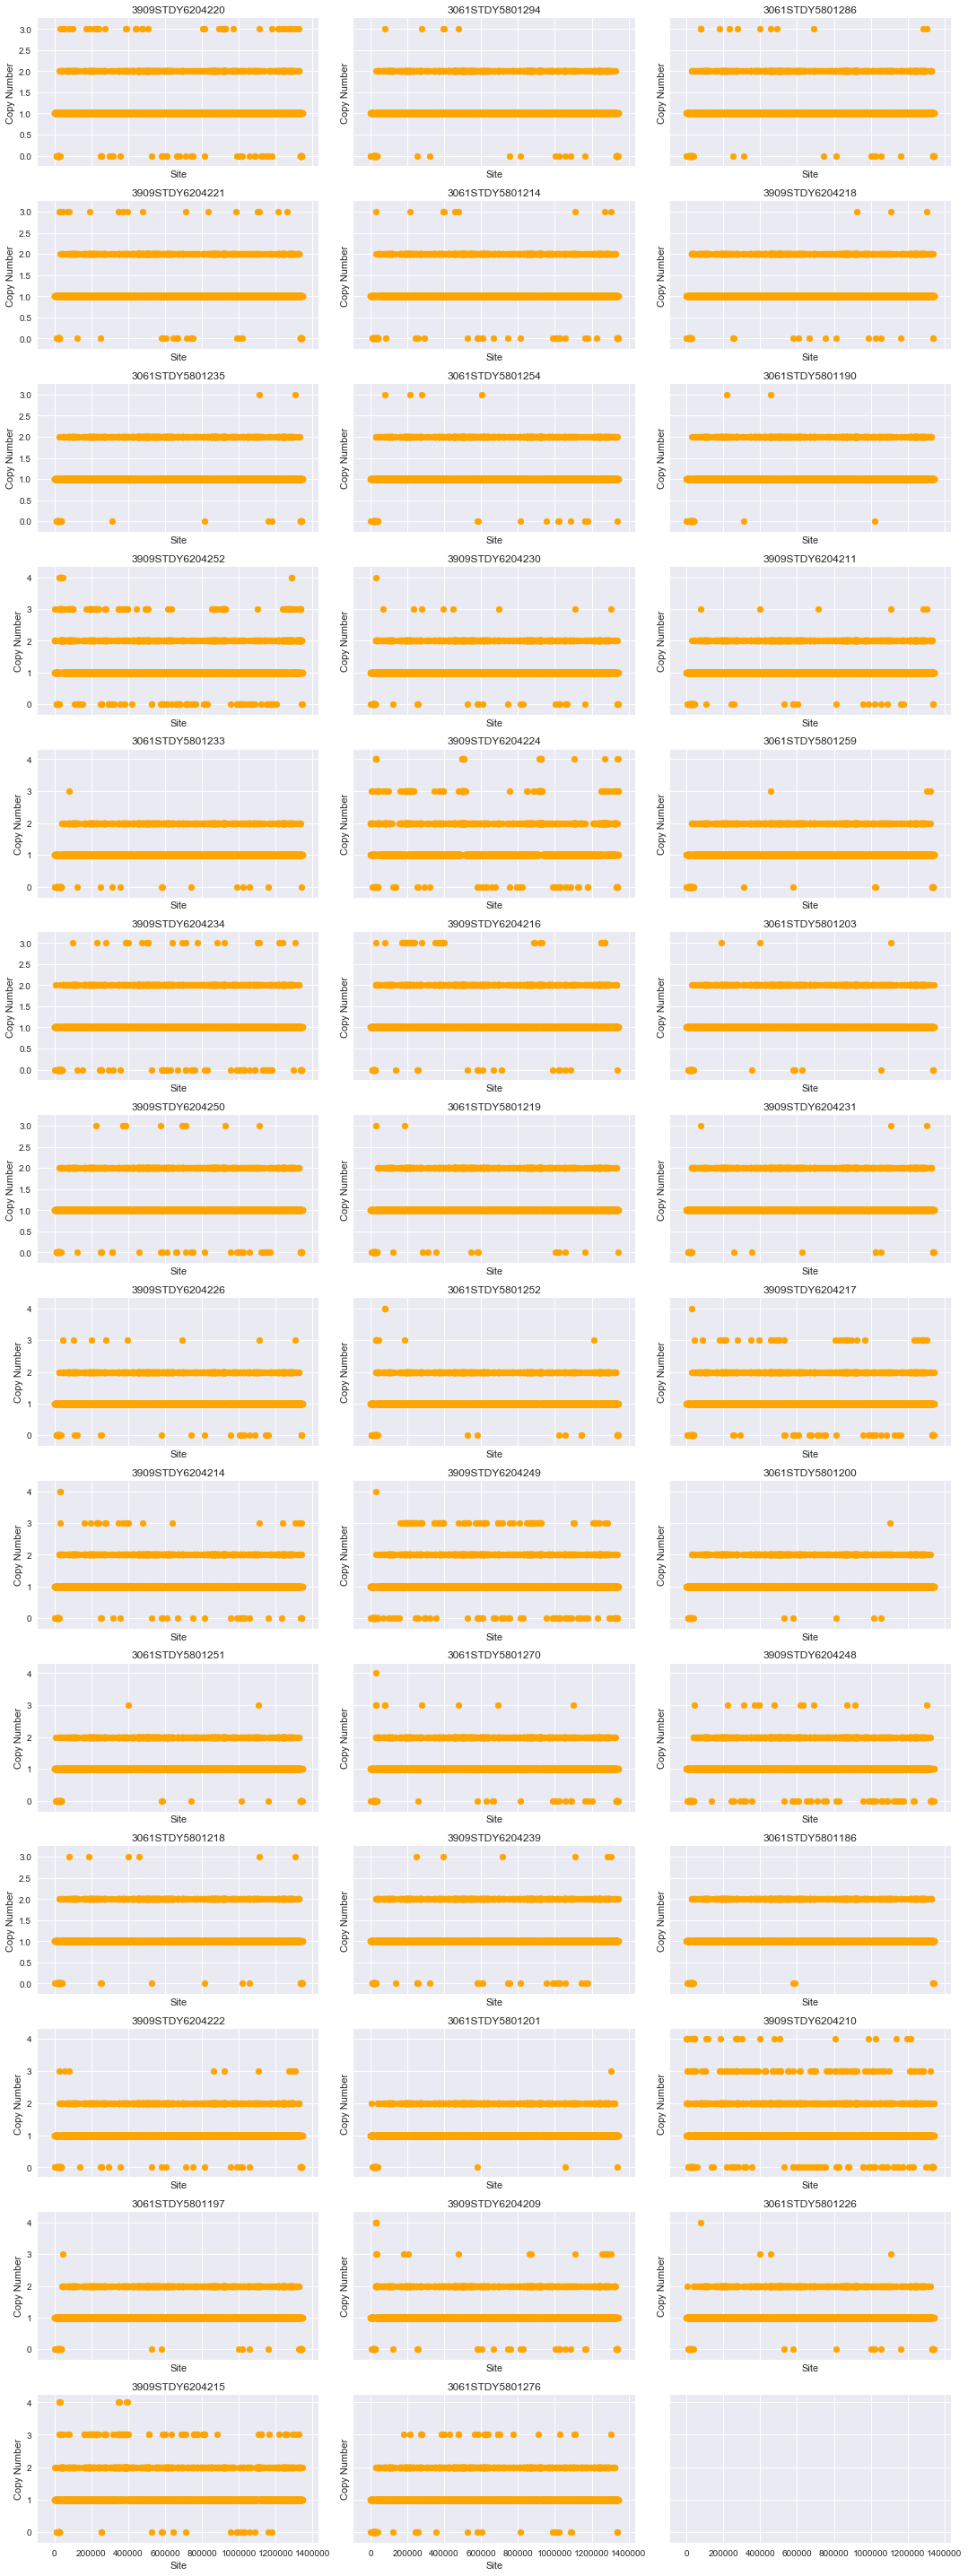

In [34]:
# row and column sharing
# Plot each sample copy number along genome
samples = cnv_calls["sample"].unique()
total_samples = len(samples)
total_cols = 3
total_rows = 1 + (total_samples // total_cols)
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey='row', figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = cnv_calls[(cnv_calls["sample"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.scatter(subset["window"], subset["copy_number"], color="orange")
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Copy Number")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()

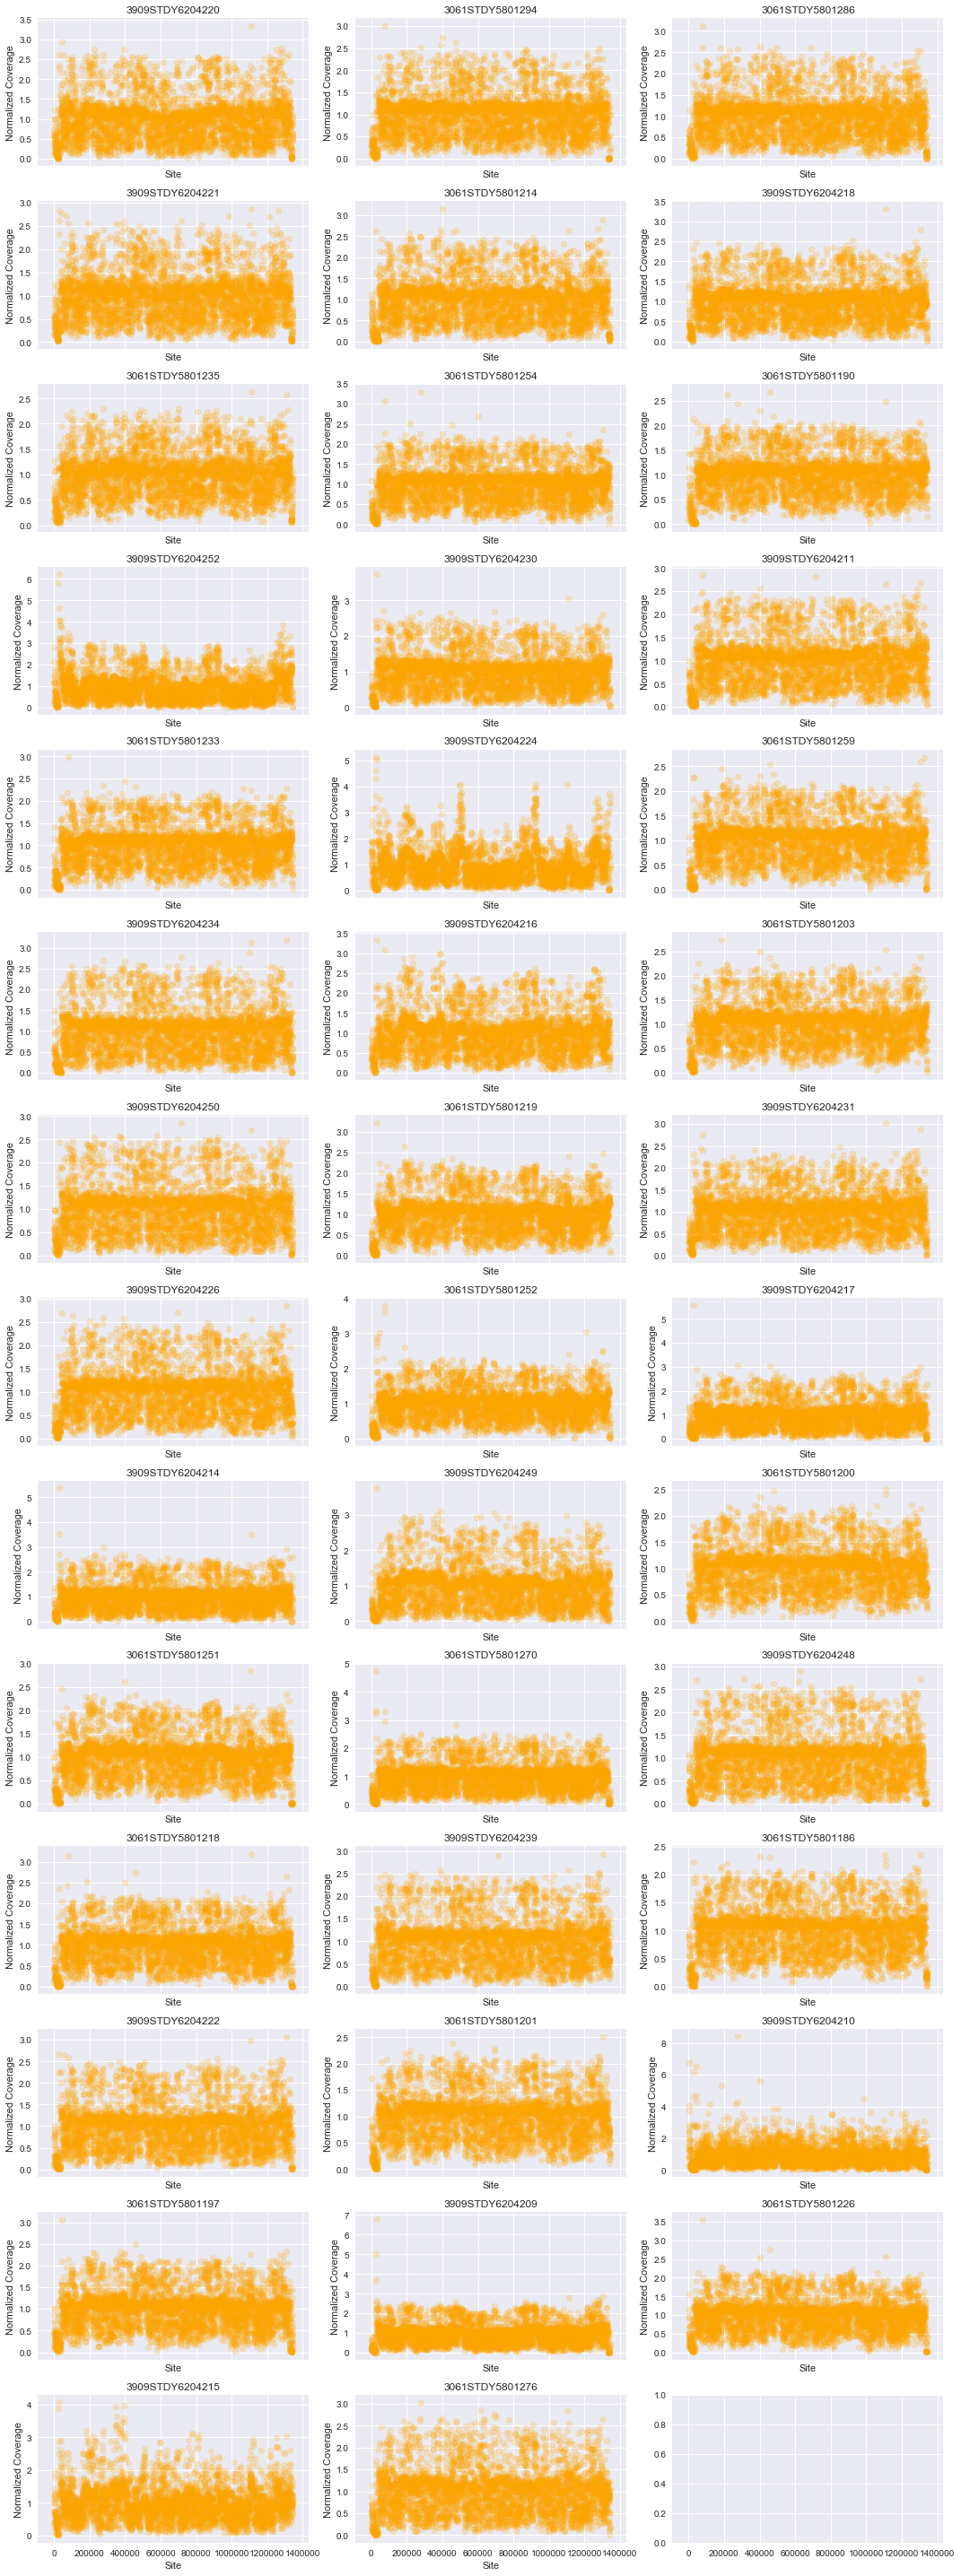

In [32]:
# Plot Normalized Coverage along genome
samples = cnv_calls["sample"].unique()
total_samples = len(samples)
total_cols = 3
total_rows = 1 + (total_samples // total_cols)
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = cnv_calls[(cnv_calls["sample"] == samples[sample_idx]) ].sort_values("window", ascending=True)
#         copy_number_line, = ax.scatter(subset["window"], subset["norm_reads_all"])
        ax.scatter(subset["window"], subset["norm_reads_all"], c="orange", alpha=0.2)
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Normalized Coverage")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()